In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

## Importing Dataset and data cleaning

In [3]:
df = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")


X= df.copy()

X=X.dropna()

y= X.pop('Transported').astype(int)

X.head()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines


### Cleaning data and removing irrelevant columns

In [4]:
#Passenger ID

X[['GroupNum','ID']] = X["PassengerId"].str.split('_', expand=True)
X['GroupNum'] = X['GroupNum'].astype(int)
X['ID'] = X['ID'].astype(int)
X.pop("PassengerId")

#Names
X.pop("Name")

#VIP and Cryosleep
X["VIP"] = X.pop("VIP").astype(int)
X["CryoSleep"] = X.pop("CryoSleep").astype(int)


#Summing amenities
print(X[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].dtypes)


X[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].apply(pd.to_numeric, errors='coerce')
print(X[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].isnull())
X["Amenities"] = X[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].fillna(0).sum(axis=1)
# X=X.drop(["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"], axis=1)

#Cabins
X[["Deck", "D_Num", "D_Side"]] = X["Cabin"].str.split('/', expand=True)
X['D_Num'] = X['D_Num'].astype(int)
X.pop("Cabin")

X.head()



RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
dtype: object
      RoomService  FoodCourt  ShoppingMall    Spa  VRDeck
0           False      False         False  False   False
1           False      False         False  False   False
2           False      False         False  False   False
3           False      False         False  False   False
4           False      False         False  False   False
...           ...        ...           ...    ...     ...
8688        False      False         False  False   False
8689        False      False         False  False   False
8690        False      False         False  False   False
8691        False      False         False  False   False
8692        False      False         False  False   False

[6606 rows x 5 columns]


,HomePlanet,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupNum,ID,VIP,CryoSleep,Amenities,Deck,D_Num,D_Side
0,Europa,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,1,1,0,0,0.0,B,0,P
1,Earth,TRAPPIST-1e,24.0,109.0,9.0,25.0,549.0,44.0,2,1,0,0,736.0,F,0,S
2,Europa,TRAPPIST-1e,58.0,43.0,3576.0,0.0,6715.0,49.0,3,1,1,0,10383.0,A,0,S
3,Europa,TRAPPIST-1e,33.0,0.0,1283.0,371.0,3329.0,193.0,3,2,0,0,5176.0,A,0,S
4,Earth,TRAPPIST-1e,16.0,303.0,70.0,151.0,565.0,2.0,4,1,0,0,1091.0,F,1,S


### Implementing One Hot encoding for categorical data

In [5]:
#other categories
columns=['HomePlanet', 'Deck', 'D_Side', 'Destination']
X_copy = X.copy()
X_copy = X_copy[columns]
X_copy = pd.get_dummies(X_copy, columns=columns)
X_copy = X_copy.astype(int)

X_old = X.copy()
X_old=X_old.drop(columns=columns)
X = X_old.join(X_copy)

X.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupNum,ID,VIP,CryoSleep,...,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,D_Side_P,D_Side_S,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,39.0,0.0,0.0,0.0,0.0,0.0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,1
1,24.0,109.0,9.0,25.0,549.0,44.0,2,1,0,0,...,0,0,1,0,0,0,1,0,0,1
2,58.0,43.0,3576.0,0.0,6715.0,49.0,3,1,1,0,...,0,0,0,0,0,0,1,0,0,1
3,33.0,0.0,1283.0,371.0,3329.0,193.0,3,2,0,0,...,0,0,0,0,0,0,1,0,0,1
4,16.0,303.0,70.0,151.0,565.0,2.0,4,1,0,0,...,0,0,1,0,0,0,1,0,0,1


## Feature Engineering

### Mutual Information

In [6]:
from sklearn.feature_selection import mutual_info_classif
mi_scores=mutual_info_classif(X, y)

In [7]:
sorted_indices = np.argsort(mi_scores)

# Select the top 20 indices in descending order (largest to smallest)
top_20_indices = sorted_indices[-20:][::-1]

print("Indices of the top 20 :")
print(top_20_indices)

cats = X.columns

print(" The top columns are:")
print(cats[top_20_indices[:6]])

Indices of the top 20 :
[10  9  1  4  5  3  2 12 25 13 19  6  0 24 17 20 11  7 18 23]
 The top columns are:
Index(['Amenities', 'CryoSleep', 'RoomService', 'Spa', 'VRDeck',
       'ShoppingMall'],
      dtype='object')


### Chi-Squared

In [8]:
from sklearn.feature_selection import chi2

statsitic, p_val = chi2(X['CryoSleep'].to_numpy()[:,None], y.to_numpy()[:, None])
if p_val < 0.05:
    print('dependent')
else:
    print('independent')
    


dependent


In [9]:
rel_cats = cats[top_20_indices]
rel_X=X[rel_cats]

### Principal Componant Analysis

In [10]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


In [11]:
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

In [12]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28
0,1.884808,-0.169204,-0.652821,-2.294374,-1.349526,-0.577542,-1.910661,0.757304,-0.674822,-1.187884,...,0.148962,-0.796541,-1.239659,0.558497,-0.503689,-1.001609e-14,1.541670e-15,-7.386034e-15,1.826588e-15,-3.695665e-16
1,-0.643721,0.587358,-1.060480,1.273785,-1.091770,0.971955,-2.233587,-0.281610,-0.935051,0.045721,...,0.062320,-0.673028,0.307472,-0.322431,0.273377,2.872887e-14,-1.246308e-14,-2.886666e-15,-2.562468e-15,-3.274143e-16
2,6.289393,0.576513,0.696761,2.389960,-2.131415,0.630346,0.723181,4.509073,-2.974788,-1.399910,...,-1.985039,0.563486,0.704317,0.523880,-0.744147,1.314302e-14,-6.446619e-15,-7.297975e-15,3.472844e-15,-5.547814e-16
3,3.579055,-0.047209,-0.906719,1.241210,-1.744278,0.140017,-0.645163,1.642755,-1.347647,-1.077545,...,-1.110893,-0.053084,-0.187402,0.565184,-0.742474,-8.554159e-15,-8.171677e-16,2.400502e-15,-3.853128e-15,3.589037e-16
4,-0.662725,0.670561,-0.997462,1.329724,-1.093362,1.061310,-2.139974,-0.586223,-0.893107,-0.140040,...,-0.105624,-0.967943,0.435797,-0.314954,0.272097,1.443248e-14,1.959182e-14,-7.597764e-15,-1.022615e-15,8.873191e-16


In [13]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28
Age,0.160509,0.094800,0.010379,0.010984,0.014198,0.037018,-0.019910,0.408317,-0.042865,0.244788,...,0.148154,0.567766,-0.024365,-0.004171,0.007428,1.001182e-16,0.000000e+00,1.159205e-16,0.000000e+00,-0.000000e+00
RoomService,0.037893,0.278344,0.030519,0.034157,0.034348,0.242838,0.240363,-0.141121,-0.035840,-0.087672,...,-0.326440,-0.071843,0.203243,0.018515,0.013508,6.124164e-02,1.355973e-01,-6.640407e-02,-4.818826e-02,1.286625e-02
FoodCourt,0.284858,-0.015590,0.206710,0.176103,-0.075912,-0.026025,0.033560,-0.048617,-0.059977,-0.001512,...,0.617116,0.129250,0.064109,-0.023636,-0.002847,1.593824e-01,3.528944e-01,-1.728177e-01,-1.254108e-01,3.348463e-02
ShoppingMall,0.040577,0.180569,0.088442,0.077260,0.036842,0.138182,-0.006293,-0.086249,0.159459,-0.071141,...,-0.061039,0.109156,0.153998,0.010229,-0.000177,5.472241e-02,1.211629e-01,-5.933530e-02,-4.305858e-02,1.149662e-02
Spa,0.218486,0.023417,0.181892,0.164756,-0.089683,0.007365,0.016088,-0.121968,-0.035763,-0.082829,...,-0.440568,-0.030075,0.043550,-0.022681,-0.006996,1.086244e-01,2.405092e-01,-1.177810e-01,-8.547161e-02,2.282089e-02
VRDeck,0.225237,-0.006025,0.204046,0.147808,-0.077185,-0.037565,-0.012643,0.037683,-0.015815,0.055835,...,-0.305468,0.209344,0.067129,-0.007565,-0.005954,1.070222e-01,2.369617e-01,-1.160438e-01,-8.421091e-02,2.248428e-02
GroupNum,-0.060658,0.021590,0.187029,0.137312,0.320250,-0.432979,0.445325,0.162042,0.274694,-0.052901,...,0.025158,-0.136167,-0.019272,-0.397229,0.389048,-1.591609e-16,-1.470178e-16,4.531965e-17,-1.557456e-16,3.274291e-17
ID,0.042532,-0.084705,-0.059467,-0.052503,0.015360,-0.174827,0.155902,-0.472130,-0.001307,-0.129819,...,0.183310,0.244431,0.054489,-0.011260,0.010527,4.683753e-17,1.179612e-16,6.245005e-17,3.295975e-17,-2.949030e-17
VIP,0.129292,0.039085,0.037892,-0.005906,0.024413,0.037371,0.201154,0.356615,-0.186570,-0.087892,...,-0.079461,-0.060458,0.088907,0.014668,0.003910,-8.847090e-17,1.422473e-16,4.336809e-17,-4.857226e-17,2.190088e-17
CryoSleep,-0.072676,-0.268453,-0.281775,-0.281495,0.112842,-0.208027,0.103797,0.018606,-0.100896,0.157638,...,-0.158737,0.285838,0.660142,-0.073775,-0.033234,-1.283695e-16,-3.469447e-17,3.122502e-17,-1.387779e-17,7.003946e-17


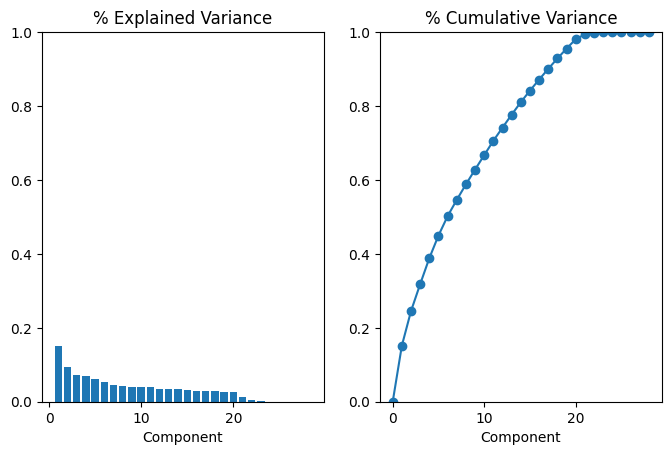

In [14]:
import matplotlib.pyplot as plt
plot_variance(pca);

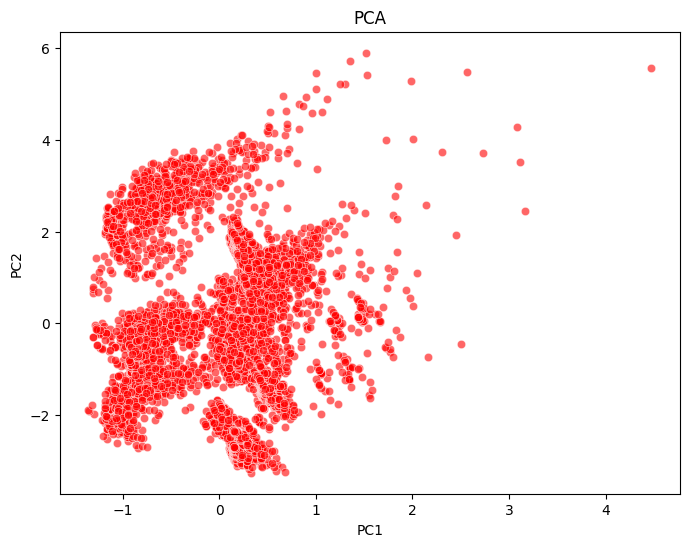

In [15]:

plt.figure(figsize=(8, 6))
sns.scatterplot(data=X_pca, x='PC21', y='PC2', color='red', alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA')
plt.show()

### Further analysis of extracted Principle Components

First Mutual Information is used to compare the influence of each component on our target.

The most relevant principle components are visualized to better understand how each feature contibutes to the component.

In [16]:
mi_scores = make_mi_scores(X_pca, y, discrete_features=False)
mi_scores

PC2     0.058591
PC21    0.057032
PC19    0.054714
PC17    0.048687
PC1     0.047613
PC3     0.043869
PC18    0.043337
PC14    0.037989
PC4     0.037062
PC6     0.026929
PC15    0.023279
PC5     0.022132
PC10    0.016543
PC22    0.015789
PC9     0.015670
PC11    0.013279
PC24    0.009321
PC13    0.006756
PC7     0.006282
PC20    0.004941
PC27    0.004807
PC26    0.000000
PC25    0.000000
PC12    0.000000
PC23    0.000000
PC8     0.000000
PC16    0.000000
PC28    0.000000
Name: MI Scores, dtype: float64

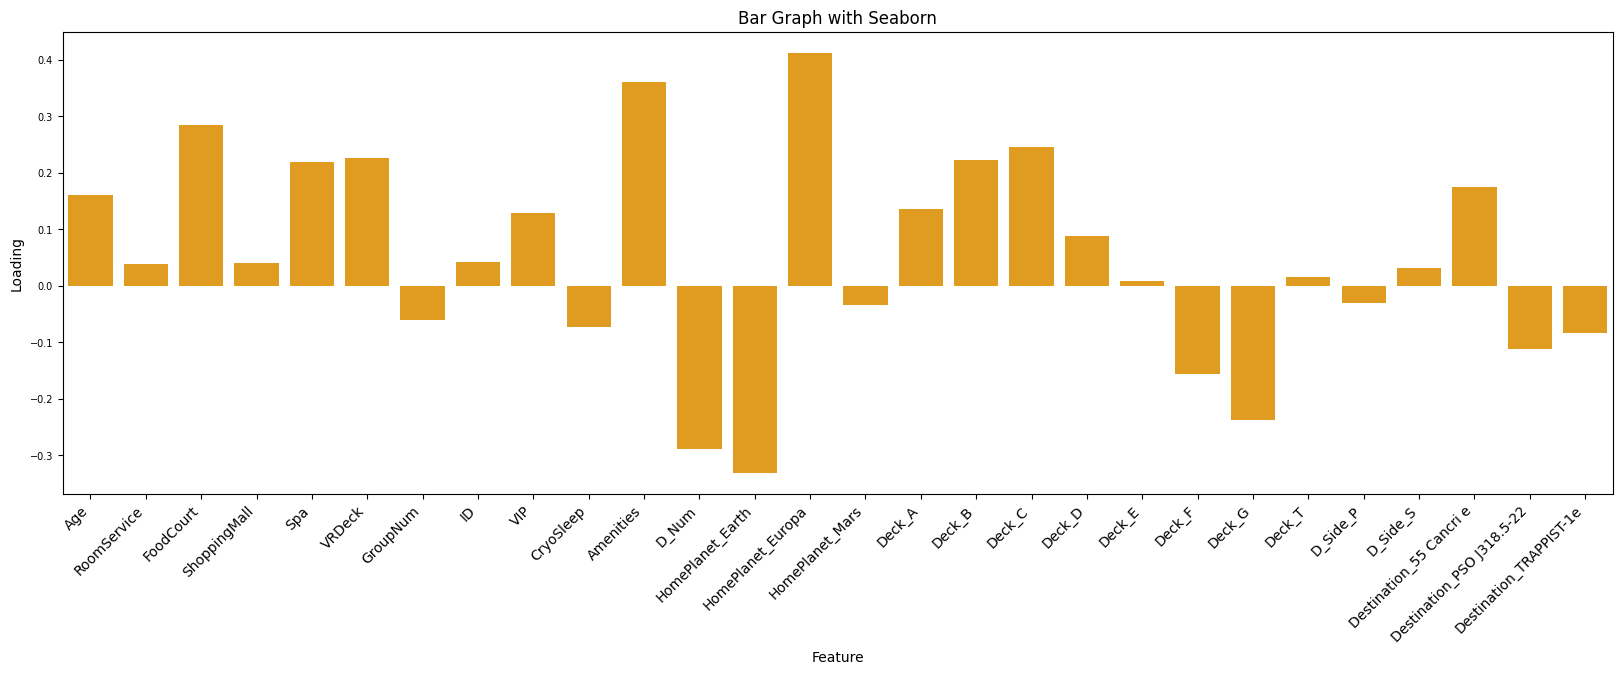

In [17]:
plt.figure(figsize=(20, 6))
sns.barplot(x=loadings.index, y=loadings['PC1'], color='orange')  # You can also add `hue` for additional categories
plt.xlabel('Feature')
plt.ylabel('Loading')
plt.xticks(rotation=45, ha='right')  # Tick label font size for x-axis
plt.yticks(fontsize=7)
plt.title('Bar Graph with Seaborn')
plt.show()

#### The most influencial components are then added as features.

In [18]:
X["Origin_Spending"]=X_pca["PC1"]
X["CryoSleep_Mars_G"]=X_pca["PC21"]
X["Mars_F_G_Des"]=X_pca["PC2"]
X["SPending"]=X_pca["PC19"]
X["VIP_SPENDING"]=X_pca["PC17"]

## Implementing A Model

Two models are pitted against one another a Fully Connected Neural Network and the other is an implementation of SVM

### SVM

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(rel_X, y, test_size = 0.10, random_state = 0) # Splittig train and test data

In [21]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [22]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

SVC(random_state=0)

In [23]:
svc_y_pred = classifier.predict(X_test)
y_test_svc=y_test.copy()

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test_svc, svc_y_pred)
# print(cm)
print("SVC :", accuracy_score(y_test_svc,svc_y_pred))

SVC : 0.7957639939485628


### Fully Conencted Neural Network

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.50, random_state = 0) # Further spliting the test data to create a validation set

2024-05-02 21:53:06.334717: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 21:53:06.334880: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 21:53:06.506146: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#### Netwrok Layout

In [26]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(20,)),  # First hidden layer
#     layers.Dropout(0.2),  # Dropout for regularization
    layers.Dense(16, activation='relu'),  # Second hidden layer
    layers.LeakyReLU(alpha=0.01),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [27]:
model.compile(optimizer='adam',  # Adam optimizer
              loss='binary_crossentropy',  # Loss function for binary classification
              metrics=['accuracy'])  

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=40,              # Number of epochs to wait for improvement
    verbose=1,               # Verbosity level
    restore_best_weights=True  # Revert to best weights on early stopping
)

In [28]:
# Train the model
model.fit(X_train, y_train, epochs=40, batch_size=1024, validation_data=(X_val, y_val), callbacks=[early_stopping])  # Train for 10 epochs
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

Epoch 1/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.4467 - loss: 0.7708 - val_accuracy: 0.4985 - val_loss: 0.7043
Epoch 2/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5042 - loss: 0.7131 - val_accuracy: 0.5861 - val_loss: 0.6639
Epoch 3/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5819 - loss: 0.6747 - val_accuracy: 0.6435 - val_loss: 0.6347
Epoch 4/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6402 - loss: 0.6407 - val_accuracy: 0.7039 - val_loss: 0.6107
Epoch 5/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7008 - loss: 0.6101 - val_accuracy: 0.7432 - val_loss: 0.5889
Epoch 6/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7148 - loss: 0.5881 - val_accuracy: 0.7492 - val_loss: 0.5692
Epoch 7/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7396 - loss: 0.5609 - val_accuracy: 0.7462 - val_loss: 0.5513
Epoch 8/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7426 - loss: 0.5387 - val_accuracy: 0.7553 - val_loss: 0.5359
Ep

In [29]:
predictions = model.predict(X_test)

# Display the predicted probabilities for a sample
print("Sample predicted probabilities:", predictions[:5].reshape(-1))  # Display first 5 predictions

# Predict classes based on a threshold of 0.5
predicted_classes = (predictions > 0.5).astype(int)
print("Sample predicted classes:", predicted_classes[:5].reshape(-1))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Sample predicted probabilities: [0.9819728  0.38404185 0.16364868 0.0691521  0.03200554]
Sample predicted classes: [1 0 0 0 0]
